<h2 align=center> Facial Expression Recognition</h2>

## Importing Libraries

In [2]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import utils
import os
%matplotlib inline

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Input, Dropout,Flatten, Conv2D
from tensorflow.keras.layers import BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model

from IPython.display import SVG, Image
from livelossplot.tf_keras import PlotLossesCallback
import tensorflow as tf
print("Tensorflow version:", tf.__version__)

Tensorflow version: 2.8.0


## Ploting Sample Images

In [4]:
# utils.datasets.fer.plot_example_images(plt).show()

## Getting total number of images of each category

In [3]:
for expression in os.listdir("train/"):
    print(str(len(os.listdir("train/" + expression))) + " " + expression + " images")

7 train images


## Generate Training and Validation Batches

In [4]:
img_size = 48
batch_size = 64

datagen_train = ImageDataGenerator(horizontal_flip=True)

train_generator = datagen_train.flow_from_directory("train/",
                                                    target_size=(img_size,img_size),
                                                    color_mode="grayscale",
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    shuffle=True)

datagen_validation = ImageDataGenerator(horizontal_flip=True)
validation_generator = datagen_validation.flow_from_directory("test/",
                                                    target_size=(img_size,img_size),
                                                    color_mode="grayscale",
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    shuffle=False)

Found 28709 images belonging to 1 classes.
Found 7178 images belonging to 1 classes.


## Create CNN Model

In [5]:
# Initialising the CNN
model = Sequential()

# 1 - Convolution
model.add(Conv2D(64,(3,3), padding='same', input_shape=(48, 48,1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 2nd Convolution layer
model.add(Conv2D(128,(5,5), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 3rd Convolution layer
model.add(Conv2D(512,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 4th Convolution layer
model.add(Conv2D(512,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Flattening
model.add(Flatten())

# Fully connected layer 1st layer
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

# Fully connected layer 2nd layer
model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(7, activation='softmax'))

opt = Adam(lr=0.0005)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 64)        640       
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 64)       256       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 48, 48, 64)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 24, 24, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 128)       2

c:\Users\321ab\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


## Visualize Model Architecture

In [7]:
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)
Image('model.png',width=400, height=200)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


## Training and Evaluating Model

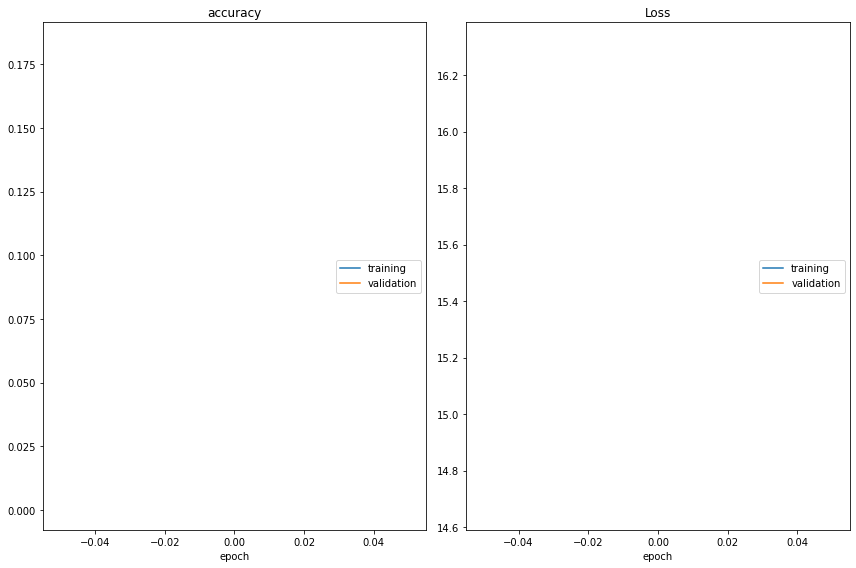

accuracy
	training         	 (min:    0.182, max:    0.182, cur:    0.182)
	validation       	 (min:    0.001, max:    0.001, cur:    0.001)
Loss
	training         	 (min:   16.305, max:   16.305, cur:   16.305)
	validation       	 (min:   14.672, max:   14.672, cur:   14.672)

Epoch 1: saving model to model_weights.h5
448/448 [==============================] - 1041s 2s/step - loss: 16.3050 - accuracy: 0.1823 - val_loss: 14.6719 - val_accuracy: 0.0013 - lr: 5.0000e-04
CPU times: total: 1h 20min 3s
Wall time: 17min 22s


In [6]:
%%time

epochs = 15
steps_per_epoch = train_generator.n//train_generator.batch_size
validation_steps = validation_generator.n//validation_generator.batch_size

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=2, min_lr=0.00001, mode='auto')
checkpoint = ModelCheckpoint("model_weights.h5", monitor='val_accuracy',
                             save_weights_only=True, mode='max', verbose=1)
callbacks = [PlotLossesCallback(), checkpoint, reduce_lr]

history = model.fit(
    x=train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data = validation_generator,
    validation_steps = validation_steps,
    callbacks=callbacks
)

## Represent Model as JSON String

In [7]:
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

## Class for loading model and weights

In [8]:
from tensorflow.keras.models import model_from_json
import numpy as np

import tensorflow as tf


class FacialExpressionModel(object):

    EMOTIONS_LIST = ["Angry", "Disgust",
                    "Fear", "Happy",
                    "Neutral", "Sad",
                    "Surprise"]

    def __init__(self, model_json_file, model_weights_file):
        # load model from JSON file
        with open(model_json_file, "r") as json_file:
            loaded_model_json = json_file.read()
            self.loaded_model = model_from_json(loaded_model_json)

        # load weights into the new model
        self.loaded_model.load_weights(model_weights_file)
        self.loaded_model.make_predict_function()

    def predict_emotion(self, img):
        self.preds = self.loaded_model.predict(img)
        return FacialExpressionModel.EMOTIONS_LIST[np.argmax(self.preds)]


## Getting frames and doing prediction

In [9]:
  
import cv2
# from model import FacialExpressionModel
import numpy as np

facec = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
model = FacialExpressionModel("model.json", "model_weights.h5")
font = cv2.FONT_HERSHEY_SIMPLEX

class VideoCamera(object):
    def __init__(self):
        self.video = cv2.VideoCapture(0)

    def __del__(self):
        self.video.release()

    # returns camera frames along with bounding boxes and predictions
    def get_frame(self):
        _, fr = self.video.read()
        gray_fr = cv2.cvtColor(fr, cv2.COLOR_BGR2GRAY)
        faces = facec.detectMultiScale(gray_fr, 1.3, 5)

        for (x, y, w, h) in faces:
            fc = gray_fr[y:y+h, x:x+w]

            roi = cv2.resize(fc, (48, 48))
            pred = model.predict_emotion(roi[np.newaxis, :, :, np.newaxis])

            cv2.putText(fr, pred, (x, y), font, 1, (255, 255, 0), 2)
            cv2.rectangle(fr,(x,y),(x+w,y+h),(255,0,0),2)

        return fr

## Function for showing output video

In [10]:
def gen(camera):
    while True:
        frame = camera.get_frame()
        cv2.imshow('Facial Expression Recognization',frame)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    cv2.destroyAllWindows()

## Running the code

In [ ]:
gen(VideoCamera())